In [ ]:
    import json
    import time
    import pandas as pd
    from openai import OpenAI
    from tqdm import tqdm
    import numpy as np
    import importlib.util # Thư viện để tải prompt động
    import sys

In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]

# 3. Định nghĩa các tác vụ và file tương ứng
TASKS = {
    "Knowledge": {
        "data_file": "Knowledge/common_knowledge.jsonl",
        "prompt_file": "Knowledge/prompt.py"
    },
    "Literature": {
        "data_file": "Literature/literature.jsonl",
        "prompt_file": "Literature/prompt.py"
    },
    "Math": {
        "data_file": "Math/math_and_logic.jsonl",
        "prompt_file": "Math/prompt.py"
    }
}

# 4. Tải dữ liệu và lấy mẫu
SAMPLE_SIZE = 200
tasks_data = {}

for task_name, paths in TASKS.items():
    try:
        with open(paths['data_file'], 'r', encoding='utf-8') as f:
            full_data = [json.loads(line) for line in f]
            tasks_data[task_name] = full_data[:SAMPLE_SIZE]
            print(f" Đã tải {len(full_data)} câu hỏi cho '{task_name}'. Sử dụng {len(tasks_data[task_name])} mẫu.")
    except FileNotFoundError:
        print(f" Lỗi: Không tìm thấy file {paths['data_file']}.")
        tasks_data[task_name] = []

 Đã tải 200 câu hỏi cho 'Knowledge'. Sử dụng 200 mẫu.
 Đã tải 200 câu hỏi cho 'Literature'. Sử dụng 200 mẫu.
 Đã tải 200 câu hỏi cho 'Math'. Sử dụng 200 mẫu.


In [3]:
def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are a helpful assistant. Please answer the multiple choice question by providing only the correct option."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=50 # Tăng token phòng trường hợp câu trả lời dài
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

def load_prompts_from_file(path):
    """
    Hàm này tải động các biến prompt từ một file .py.
    """
    spec = importlib.util.spec_from_file_location("prompt_module", path)
    prompt_module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(prompt_module)
    return {
        "English Prompt (Zero-shot)": prompt_module.ENGLISH_ZERO,
        "English Prompt (Few-shot)": prompt_module.ENGLISH_ONE,
        "Persian Prompt (Zero-shot)": prompt_module.PERSIAN_ZERO,
        "Persian Prompt (Few-shot)": prompt_module.PERSIAN_ONE,
    }

In [4]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn
for task_name, all_data in tasks_data.items():
    if not all_data:
        continue
    
    print(f"\n\n==================== BẮT ĐẦU TÁC VỤ: {task_name} ====================")
    final_results[task_name] = {}
    
    # Tải các prompt tương ứng với tác vụ
    prompts_to_test = load_prompts_from_file(TASKS[task_name]['prompt_file'])
    true_answers = [sample['target'] for sample in all_data]

    for model_name in MODELS_TO_COMPARE:
        final_results[task_name][model_name] = {}
        print(f"---------- Bắt đầu Model: {model_name} ----------")

        for prompt_name, prompt_template in prompts_to_test.items():
            print(f"--- Đang chạy kịch bản: {prompt_name} ---")
            
            model_predictions = []
            
            for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
                prompt = prompt_template.format(question=sample['question'], candidates=sample['candidates'])
                answer = get_answer_from_model(prompt, model_name)
                model_predictions.append(answer)
                time.sleep(1)

            # Lưu lại danh sách các câu trả lời của model
            final_results[task_name][model_name][prompt_name] = model_predictions
            print(f"--- Hoàn thành thu thập dữ liệu cho kịch bản: {prompt_name} ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")



==================== BẮT ĐẦU TÁC VỤ: Knowledge ====================
---------- Bắt đầu Model: gpt-3.5-turbo ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot):   0%|          | 0/200 [00:00<?, ?it/s]

Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:46<00:00,  1.73s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [05:36<00:00,  1.68s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

---------- Bắt đầu Model: gpt-4o-mini ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:42<00:00,  1.71s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [05:43<00:00,  1.72s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [06:08<00:00,  1.84s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:38<00:00,  1.69s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---



==================== BẮT ĐẦU TÁC VỤ: Literature ====================
---------- Bắt đầu Model: gpt-3.5-turbo ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:47<00:00,  1.74s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [05:40<00:00,  1.70s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [15:48<00:00,  4.74s/it]   


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:48<00:00,  1.74s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

---------- Bắt đầu Model: gpt-4o-mini ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [06:03<00:00,  1.82s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [06:21<00:00,  1.91s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [06:04<00:00,  1.82s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:57<00:00,  1.79s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---



==================== BẮT ĐẦU TÁC VỤ: Math ====================
---------- Bắt đầu Model: gpt-3.5-turbo ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [05:28<00:00,  1.64s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [15:27<00:00,  4.64s/it] 


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:21<00:00,  1.61s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

---------- Bắt đầu Model: gpt-4o-mini ----------
--- Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [05:39<00:00,  1.70s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- Đang chạy kịch bản: English Prompt (Few-shot) ---


Querying English Prompt (Few-shot): 100%|██████████| 200/200 [05:31<00:00,  1.66s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Few-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [05:36<00:00,  1.68s/it]


--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- Đang chạy kịch bản: Persian Prompt (Few-shot) ---


Querying Persian Prompt (Few-shot): 100%|██████████| 200/200 [05:40<00:00,  1.70s/it]

--- Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Few-shot) ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

accuracy_results = {}
def normalize_text(text):
    return str(text).strip().lower()

for task_name, model_results in final_results.items():
    true_answers = [sample['target'] for sample in tasks_data[task_name]]
    for model_name, prompt_results in model_results.items():
        for prompt_name, predictions in prompt_results.items():
            correct_count = np.array([1 if normalize_text(true_ans) in normalize_text(pred) else 0 for pred, true_ans in zip(predictions, true_answers)]).sum()
            accuracy = (correct_count / len(true_answers)) * 100
            if model_name not in accuracy_results:
                accuracy_results[model_name] = {}
            if task_name not in accuracy_results[model_name]:
                accuracy_results[model_name][task_name] = {}
            accuracy_results[model_name][task_name][prompt_name] = accuracy

summary_data = []
for model in MODELS_TO_COMPARE:
    # Tính điểm trung bình cho PersianMath
    math_scores = accuracy_results.get(model, {}).get('Math', {}).values()
    avg_math_score = np.mean(list(math_scores)) if math_scores else 0
    summary_data.append({"Tác vụ": "PersianMath", "Model": model, "Accuracy": avg_math_score})

    # Tính điểm trung bình cho PersianSAT (gộp Knowledge và Literature)
    knowledge_scores = accuracy_results.get(model, {}).get('Knowledge', {}).values()
    literature_scores = accuracy_results.get(model, {}).get('Literature', {}).values()
    sat_scores = list(knowledge_scores) + list(literature_scores)
    avg_sat_score = np.mean(sat_scores) if sat_scores else 0
    summary_data.append({"Tác vụ": "PersianSAT", "Model": model, "Accuracy": avg_sat_score})
    
# Tạo DataFrame từ dữ liệu đã tổng hợp
summary_df = pd.DataFrame(summary_data)

# --- Hiển thị bảng so sánh ---
final_pivot_table = summary_df.pivot_table(index="Tác vụ", columns="Model", values="Accuracy")
print("\n\n📊=============== Bảng: So sánh độ chính xác của trắc nghiệm (PersianMath & PersianSAT) ===============📊")
print(final_pivot_table.to_markdown(floatfmt=".2f"))



📊=============== Bảng: So sánh độ chính xác của trắc nghiệm (PersianMath & PersianSAT) ===============📊
| Tác vụ      |   gpt-3.5-turbo |   gpt-4o-mini |
|:------------|----------------:|--------------:|
| PersianMath |           43.50 |         53.00 |
| PersianSAT  |           35.56 |         53.88 |




📈=============== Biểu đồ so sánh hiệu suất PersianMath & PersianSAT ===============📈


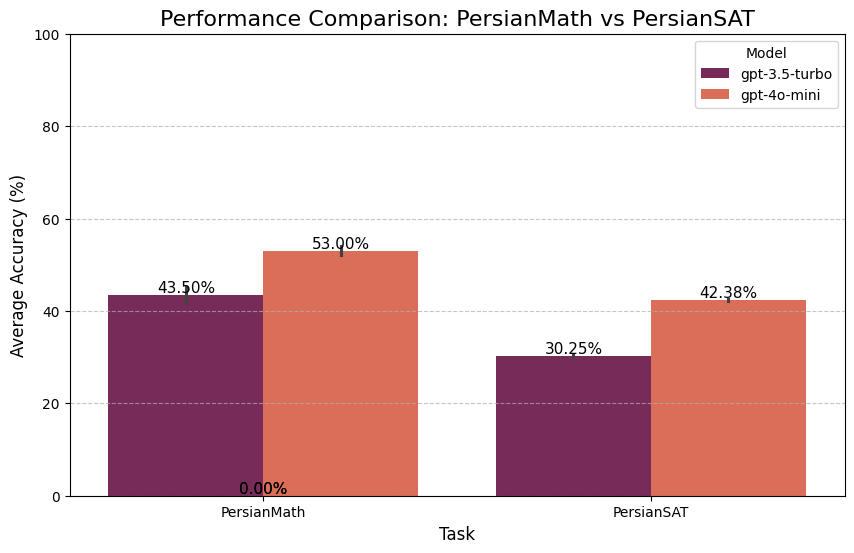

In [15]:
# --- Vẽ biểu đồ so sánh ---
print("\n\n📈=============== Biểu đồ so sánh hiệu suất PersianMath & PersianSAT ===============📈")
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Tác vụ', y='Accuracy', hue='Model', palette='rocket')

# Tùy chỉnh biểu đồ
plt.title('Performance Comparison: PersianMath vs PersianSAT', fontsize=16)
plt.ylabel('Average Accuracy (%)', fontsize=12)
plt.xlabel('Task', fontsize=12)
plt.ylim(0, 100)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()